# Cytosol Only Cellpose Segmentation with adapted parameters to cellpose model call

In [1]:
import os
import numpy as np
import pandas as pd

from scportrait.pipeline.featurization import CellFeaturizer
from scportrait.pipeline.extraction import HDF5CellExtraction
from scportrait.pipeline.project import Project
from scportrait.pipeline.segmentation.workflows import CytosolOnlySegmentationCellpose
from scportrait.pipeline.selection import LMDSelection
import scportrait

In [2]:
project_location = "project_cytosol_only_custom_segmentation"
config_path = scportrait.data.get_config_file(config_id="dataset_1_custom_cellpost_config")

project = Project(
    os.path.abspath(project_location),
    config_path=config_path,
    overwrite=True,
    debug=True,
    segmentation_f=CytosolOnlySegmentationCellpose,
    extraction_f=HDF5CellExtraction,
    featurization_f=CellFeaturizer,
    selection_f=LMDSelection,
)

Updating project config file.
[10/04/2025 18:53:10] Loading config from /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/config.yml
[10/04/2025 18:53:10] Compression algorithm for extracted single-cell images: lzf
[10/04/2025 18:53:10] No cache directory specified in config using current working directory /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1.


In [3]:
dataset_1_path = scportrait.data.dataset_1()

# these example images are downloaded from the human protein atlas (www.proteinatlas.org)
images = [f"{dataset_1_path}/Ch1.tif", f"{dataset_1_path}/Ch2.tif", f"{dataset_1_path }/Ch3.tif"]

project.load_input_from_tif_files(images, channel_names = ["Hoechst", "Alexa488", "mCherry"])

[10/04/2025 18:53:10] Output location /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/scportrait.sdata already exists. Overwriting.
INFO     The Zarr backing store has been changed from None the new file path:                                      
         /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_on
         ly_custom_segmentation/scportrait.sdata                                                                   


[10/04/2025 18:53:10] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/Project_efgyp3qs for Project
[10/04/2025 18:53:10] Image input_image written to sdata object.
[10/04/2025 18:53:11] Cleaned up temporary directory at <TemporaryDirectory '/Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/Project_efgyp3qs'>


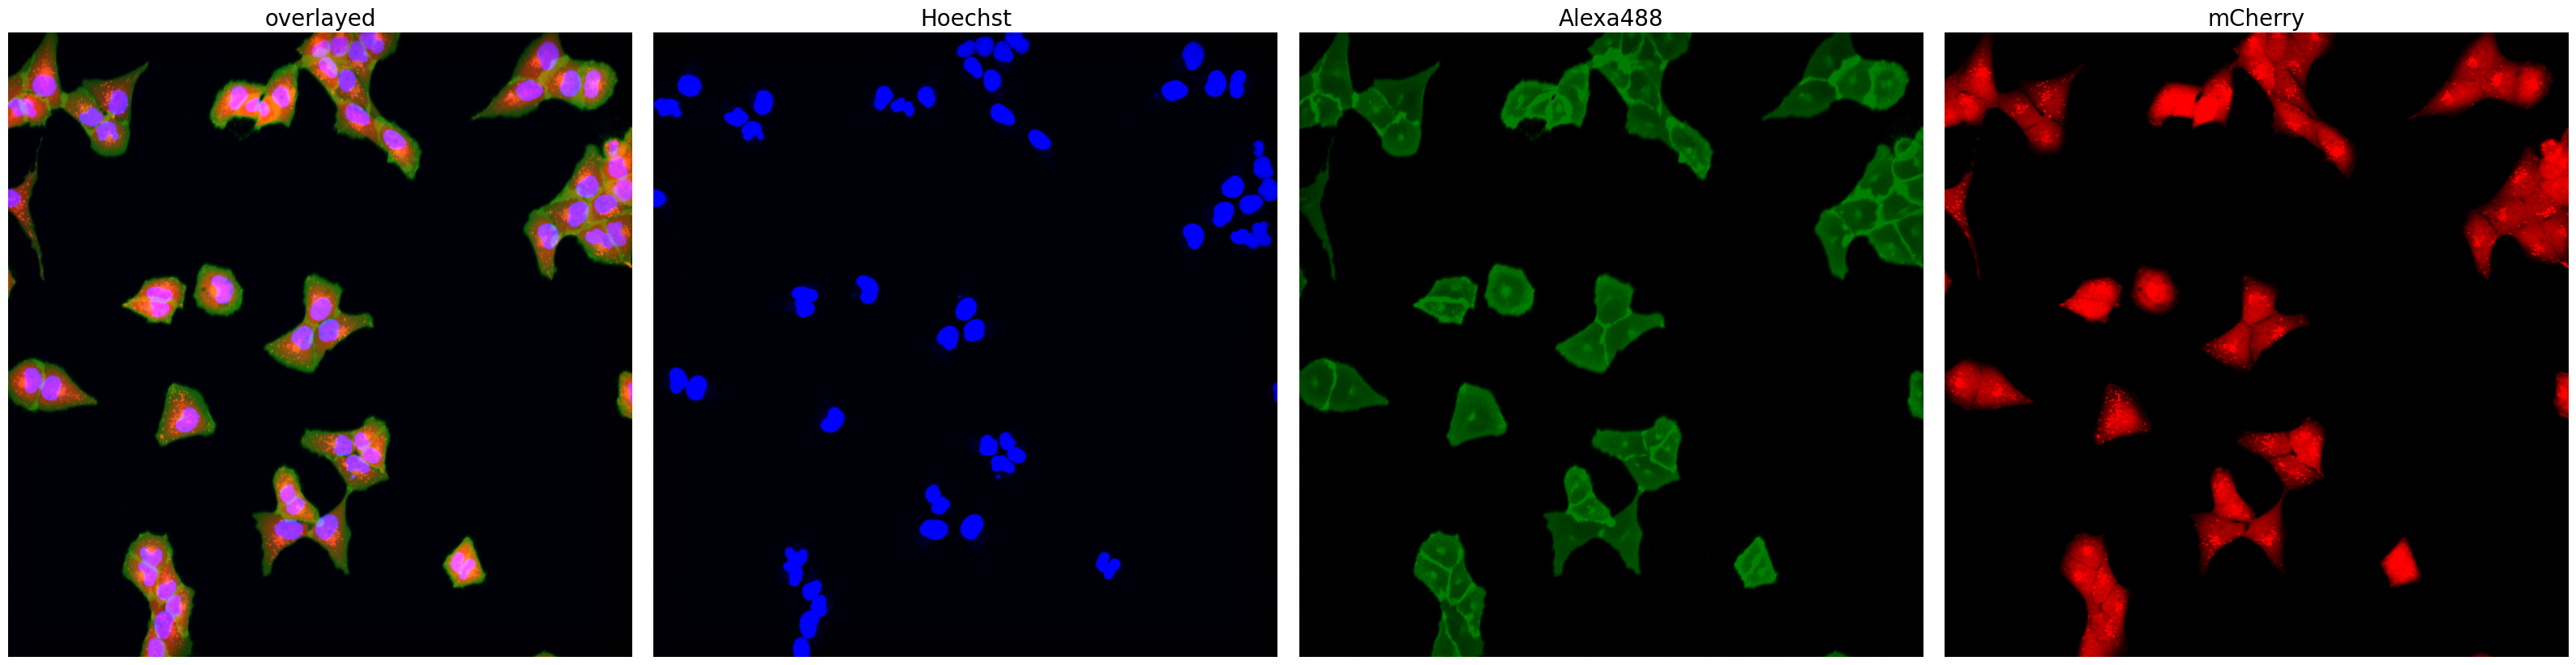

In [4]:
project.plot_input_image()

In [5]:
from scportrait.data._datasets import custom_cellpose_model
custom_model_path = custom_cellpose_model()

project.config["CytosolOnlySegmentationCellpose"]["cytosol_segmentation"]["model_path"] = custom_model_path
project._update_segmentation_f(CytosolOnlySegmentationCellpose)

In [6]:
project.segment()

[10/04/2025 18:53:12] GPU Status for segmentation is True and will segment using the following device mps.
[10/04/2025 18:53:12] Segmentation will be performed wtih all 1 found GPUs.
[10/04/2025 18:53:12] GPU Status for segmentation is True with 1 GPUs found. Segmentation will be performed on the device mps with 1 processes per device in parallel.
[10/04/2025 18:53:12] Segmenting cytosol using the following model: /Users/sophia/Documents/GitHub/scPortrait/src/scportrait/scportrait_data/custom_cellpose_model/custom_cellpose_model.cpkt
[10/04/2025 18:53:20] Segmentation seg_all_cytosol written to sdata object.
[10/04/2025 18:53:21] Points centers_seg_all_cytosol written to sdata object.


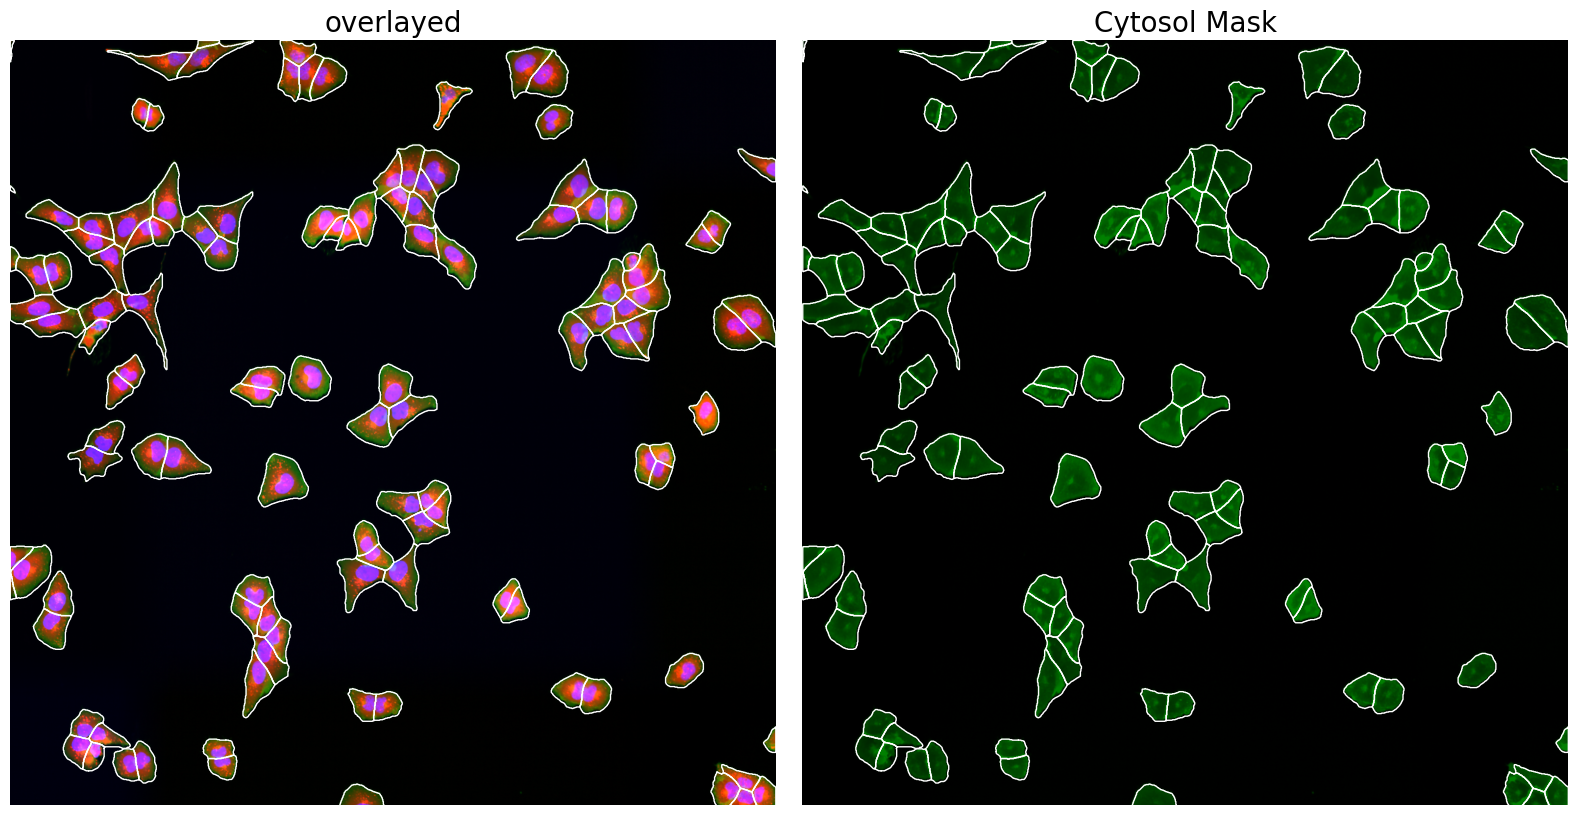

In [7]:
project.plot_segmentation_masks()

In [8]:
project.extract()

[10/04/2025 18:53:23] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_pwtp9s1n for HDF5CellExtraction
[10/04/2025 18:53:23] Created new directory for extraction results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/extraction/data
[10/04/2025 18:53:23] Setup output folder at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/extraction/data
[10/04/2025 18:53:23] Found 1 segmentation masks for the given key in the sdata object. Will be extracting single-cell images based on these masks: ['seg_all_cytosol']
[10/04/2025 18:53:23] Using seg_all_cytosol as the main segmentation mask to determine cell centers.
[10/04/2025 18:53:23] A total of 15 cells were too close to the image border to be extracted. Their cell_ids were saved to file /Users/sophia/Documents/GitHub/scPortrait

Extracting cell batches:   0%|          | 0/5 [00:00<?, ?it/s]

[10/04/2025 18:53:24] Finished extraction in 0.46 seconds (970.85 cells / second)
[10/04/2025 18:53:24] Benchmarking times saved to file.
[10/04/2025 18:53:24] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./HDF5CellExtraction_pwtp9s1n'>


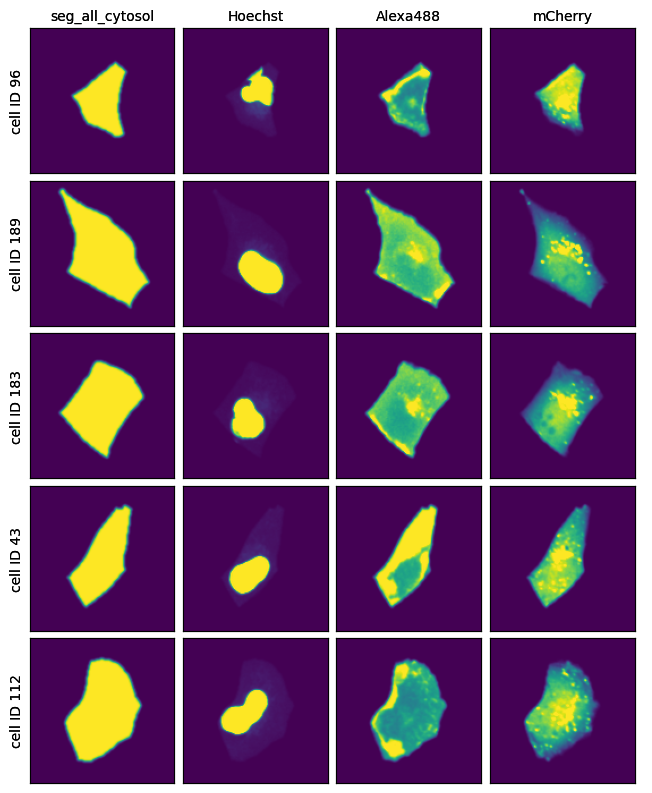

In [9]:
project.plot_single_cell_images()

In [10]:
project.featurize(overwrite=True)

Using extraction directory: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/extraction/data/single_cells.h5sc
[10/04/2025 18:53:24] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/CellFeaturizer_r5tucz_q for CellFeaturizer
[10/04/2025 18:53:24] Started CellFeaturization of all available channels.
[10/04/2025 18:53:24] Created new directory for featurization results: /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/featurization/complete_CellFeaturizer
[10/04/2025 18:53:24] CPU specified in config file but MPS available on system. Consider changing the device for the next run.
[10/04/2025 18:53:24] Initialized temporary directory at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/CellFeaturizer_we5_ylwv for CellFeat

In [13]:
# load classification results
results = project.sdata['CellFeaturizer_cytosol'].to_df().merge(project.sdata['CellFeaturizer_cytosol'].obs, left_index=True, right_index=True).drop(columns = "region")
results

,cytosol_area,Hoechst_mean_cytosol,Hoechst_median_cytosol,Hoechst_quant75_cytosol,Hoechst_quant25_cytosol,Hoechst_summed_intensity_cytosol,Hoechst_summed_intensity_area_normalized_cytosol,Alexa488_mean_cytosol,Alexa488_median_cytosol,Alexa488_quant75_cytosol,Alexa488_quant25_cytosol,Alexa488_summed_intensity_cytosol,Alexa488_summed_intensity_area_normalized_cytosol,mCherry_mean_cytosol,mCherry_median_cytosol,mCherry_quant75_cytosol,mCherry_quant25_cytosol,mCherry_summed_intensity_cytosol,mCherry_summed_intensity_area_normalized_cytosol,scportrait_cell_id
0,6873.0,0.073960,0.0,0.026337,0.0,1211.754272,0.176306,0.238977,0.0,6.757812e-01,0.0,3915.391846,0.569677,0.138560,0.0,1.538086e-01,0.0,2270.161621,0.330301,24
1,4115.0,0.055963,0.0,0.000000,0.0,916.898254,0.222819,0.116050,0.0,2.980232e-07,0.0,1901.356934,0.462055,0.107417,0.0,1.192093e-07,0.0,1759.924927,0.427685,25
2,3336.0,0.045540,0.0,0.000000,0.0,746.122192,0.223658,0.101582,0.0,0.000000e+00,0.0,1664.312500,0.498895,0.090743,0.0,0.000000e+00,0.0,1486.734619,0.445664,28
3,5174.0,0.074726,0.0,0.014950,0.0,1224.306763,0.236627,0.202450,0.0,1.155396e-01,0.0,3316.944336,0.641079,0.153300,0.0,2.598953e-02,0.0,2511.666016,0.485440,29
4,5612.0,0.058247,0.0,0.013548,0.0,954.319702,0.170050,0.170601,0.0,1.654358e-01,0.0,2795.125977,0.498062,0.136547,0.0,2.786636e-02,0.0,2237.191162,0.398644,30
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
443,4145.0,0.034823,0.0,0.000000,0.0,570.542725,0.137646,0.143054,0.0,5.960464e-08,0.0,2343.795410,0.565451,0.097405,0.0,0.000000e+00,0.0,1595.876343,0.385012,501
444,3123.0,0.057396,0.0,0.000000,0.0,940.370361,0.301111,0.099159,0.0,0.000000e+00,0.0,1624.612915,0.520209,0.080199,0.0,0.000000e+00,0.0,1313.973022,0.420741,502
445,5376.0,0.038559,0.0,0.001300,0.0,631.742920,0.117512,0.201304,0.0,1.752930e-01,0.0,3298.160645,0.613497,0.124276,0.0,8.497238e-03,0.0,2036.137451,0.378746,503
446,5421.0,0.051782,0.0,0.002118,0.0,848.396729,0.156502,0.172909,0.0,2.497559e-01,0.0,2832.942871,0.522587,0.131126,0.0,3.575897e-02,0.0,2148.371582,0.396305,504


In [14]:
#test selection workflow
selected_cells_large = results[results.cytosol_area > 4500]["scportrait_cell_id"].tolist()
selected_cells_small = results[results.cytosol_area < 3000]["scportrait_cell_id"].tolist()

cells_to_select = [
    {"name": "large_cells", "classes": selected_cells_large, "well": "A1"},
    {"name": "small_cells", "classes": selected_cells_small, "well": "B1"},
]

marker_0 = (0, 0)
marker_1 = (2000, 0)
marker_2 = (0, 2000)

calibration_marker = np.array([marker_0, marker_1, marker_2])

[10/04/2025 18:53:58] Initialized temporary directory at /var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./LMDSelection_1_4pylgi for LMDSelection
[10/04/2025 18:53:58] Selection process started.


Processing cell batches:   0%|          | 0/3 [00:00<?, ?it/s]

[10/04/2025 18:54:06] Temporary directory not found, skipping cleanup
[10/04/2025 18:54:06] Temporary directory not found, skipping cleanup
[10/04/2025 18:54:06] Temporary directory not found, skipping cleanup
[10/04/2025 18:54:07] Coordinate lookup index calculation took 8.855127249989891 seconds.
No configuration for shape_erosion found, parameter will be set to 0
No configuration for binary_smoothing found, parameter will be set to 3
No configuration for convolution_smoothing found, parameter will be set to 15
No configuration for rdp_epsilon found, parameter will be set to 0.1
No configuration for xml_decimal_transform found, parameter will be set to 100
No configuration for distance_heuristic found, parameter will be set to 300
No configuration for join_intersecting found, parameter will be set to True
Path optimizer used for XML generation: hilbert
cell set 0 passed sanity check
cell set 1 passed sanity check
Loading coordinates from external source
Processing cell sets in parall

collecting cell sets:   0%|          | 0/2 [00:00<?, ?it/s]

Convert label format into coordinate format
Conversion finished, performing sanity check.
Intersecting Shapes will be merged into a single shape.
Convert label format into coordinate format
Conversion finished, performing sanity check.
Intersecting Shapes will be merged into a single shape.


dilating shapes: 100%|██████████| 204/204 [00:05<00:00, 38.04it/s]


0 shapes that were intersecting were found and merged.


calculating polygons:   0%|          | 0/43 [00:00<?, ?it/s]

0 shapes that were intersecting were found and merged.


calculating polygons: 100%|██████████| 43/43 [00:05<00:00,  7.35it/s]


Current path length: 44,526.64 units


calculating polygons:   0%|          | 0/77 [00:00<?, ?it/s]

Optimized path length: 18,776.76 units
Optimization factor: 2.4x
Plotting shapes in debug mode is not supported in multi-threading mode.
Saving plots to disk instead.


calculating polygons: 100%|██████████| 77/77 [00:18<00:00,  4.20it/s]


Current path length: 83,641.73 units
Optimized path length: 26,316.26 units
Optimization factor: 3.2x
Plotting shapes in debug mode is not supported in multi-threading mode.
Saving plots to disk instead.


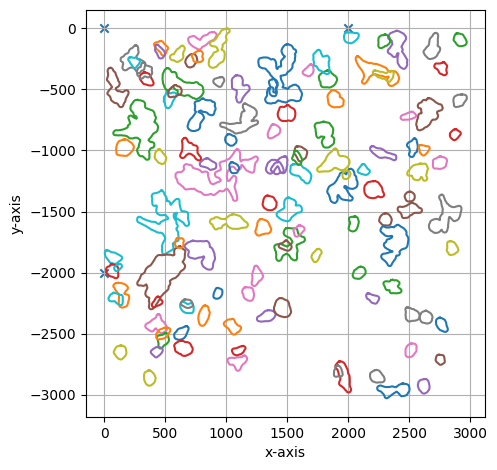

===== Collection Stats =====
Number of shapes: 120
Number of vertices: 17,195
Mean vertices: 143
Min vertices: 53
5% percentile vertices: 70
Median vertices: 100
95% percentile vertices: 306
Max vertices: 722
[0 0]
[      0 -200000]
[200000      0]
[10/04/2025 18:54:46] Saved output at /Users/sophia/Documents/GitHub/scPortrait/examples/notebooks/example_projects/example_1/project_cytosol_only_custom_segmentation/selection/large_cells_small_cells.xml
[10/04/2025 18:54:47] Cleaned up temporary directory at <TemporaryDirectory '/var/folders/35/p4c58_4n3bb0bxnzgns1t7kh0000gn/T/./LMDSelection_1_4pylgi'>


In [15]:
project.selection_f.segmentation_channel_to_select = "seg_all_cytosol" #update to the correct channel for this notebook with out loading a different config
project.select(cells_to_select, calibration_marker)